# IREN - Navires 2021 à la mano

## Authors

- Theo Lepage (theo.lepage)
- Nicolas Blin (nicolas.blin)

Group: **Check this out Google**

## Table of content

1. [Load and prepare data (_train_, _val_ and _test_ sets)](#section-one)
    - 1.1 [Analyse data and visualize images](#section-dataset-1)
    - 1.2 [Create _test_ set manually](#section-dataset-2)
    - 1.3 [Create data generators for _train_ and _val_ sets](#section-dataset-3)
2. [Create the model](#section-two)
3. [Train the model](#section-three)
    - 3.1 [Configure optimizer and callbacks](#section-train-1)
    - 3.2 [Trainings](#section-train-2)
4. [Evaluate the model](#section-four)
    - 4.1 [Scores](#section-evaluate-1)
    - 4.2 [Learning curves](#section-evaluate-2)
    - 4.3 [Confusion matrix](#section-evaluate-3)
    - 4.4 [Results analysis](#section-evaluate-4)
    - 4.5 [Test with our own images](#section-evaluate-5)
    - 4.6 [Conclusion](#section-evaluate-6)
5. [Submit results for competition](#section-five)

In [1]:
SEED = 1717

TRAIN_PATH = '/kaggle/working/ships_scaled/train/'
TEST_PATH = '/kaggle/working/ships_scaled/test/'
NB_TEST_IMAGES_PER_CLASS = 100

CATEGORIES = ['coastguard',        # bateau garde-côtes
              'containership',     # bateau porte-conteneurs
              'corvette',          # petit navire de guerre
              'cruiser',           # bateau de croisière
              'cv',                # porte-avions
              'destroyer',         # navire de guerre avec missiles
              'ferry',             # ferry
              'methanier',         # navire transportant du gaz
              'sailing',           # bateau à voiles
              'smallfish',         # bateau de peche
              'submarine',         # sous-marin
              'tug',               # remorqueur
              'vsmallfish']        # bateau de peche (plus petit)

NB_CLASSES = len(CATEGORIES)

IMG_DIM = (128, 128)
BATCH_SIZE = 64
VAL_SPLIT = 0.1

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
!nvidia-smi

Mon Apr 26 21:29:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id="section-one"></a>

# Load and prepare data (_train_, _val_ and _test_ sets)

We are going to create three separate sets:
- A _test_ set (`NB_TEST_IMAGES_PER_CLASS` images per category from the original train set)
- A _train_ set (90% of the remaining samples, with data augmentation)
- A _validation_ set (10% of the remaining samples, with data augmentation)


All values are normalized between `0.0` and `1.0`.

In [4]:
# Extract ships.tgz
!tar xzf /kaggle/input/shipsmano2021/ships.tgz
!ls /kaggle/working/ships_scaled/train/

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


## Analyse data and visualize images

<a id="section-dataset-1"></a>

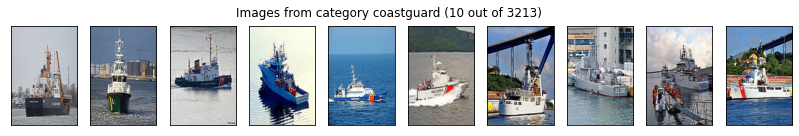

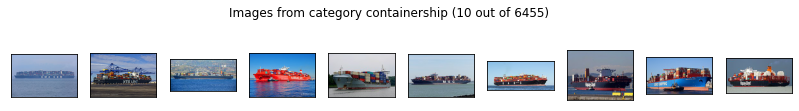

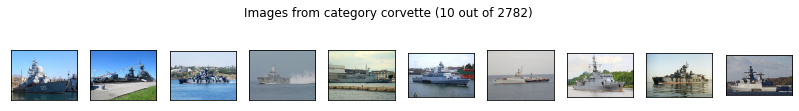

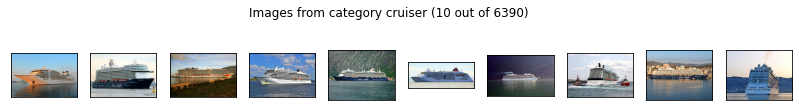

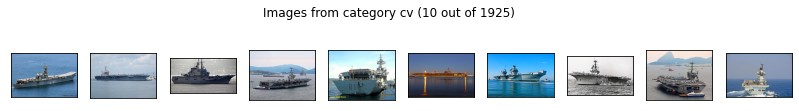

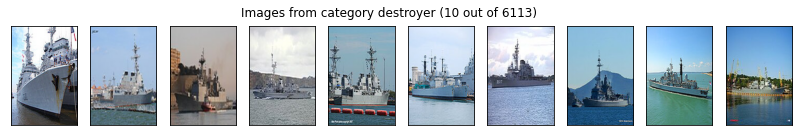

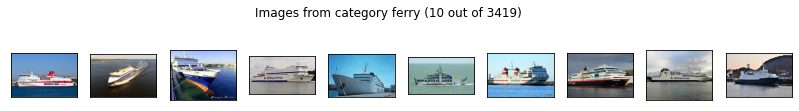

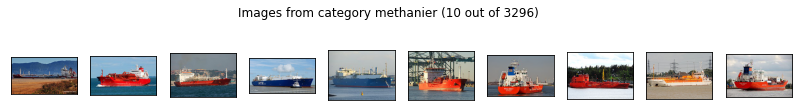

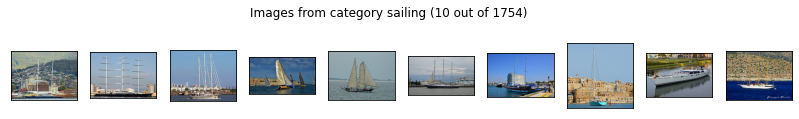

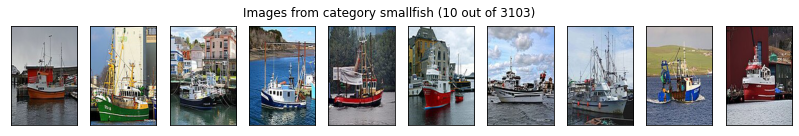

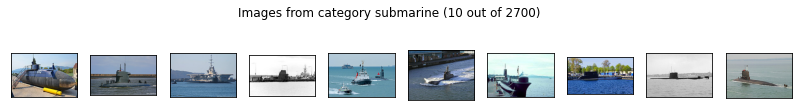

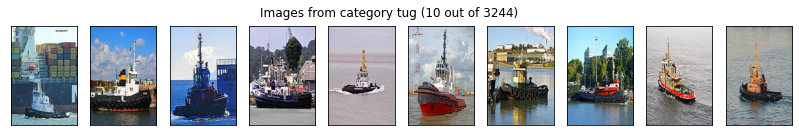

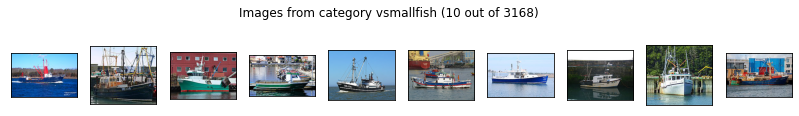

In [5]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

nb_images_per_class_to_show = 10

nb_samples = 0
nb_images_per_class = {}

def get_images_of_class(category):
    images = []
    images_path = glob.glob(TRAIN_PATH + category + '/*.jpg')
    for path in images_path[0:nb_images_per_class_to_show]:
        images.append(Image.open(path))
    return images, len(images_path)

# Show images for each category
for c, category in enumerate(CATEGORIES):
    plt.figure(figsize=[14, 2])
    
    images, count = get_images_of_class(category)
    nb_images_per_class[c] = count
    nb_samples += count
    
    fig = plt.gcf()
    fig.suptitle("Images from category {} ({} out of {})".format(category,
                                                                 nb_images_per_class_to_show,
                                                                 count))
    
    for i, img in enumerate(images):
        plt.subplot(1, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
    plt.show()

**Observations**:
- Images are taken from land or sea and are centered around the ship.
- The dataset is not balanced (i.e. we do not have the same number of images for each category).
- Most categories are in landscape orientation but categories `coastguard`, `destroyer`, `smallfish`, `tug` are in portrait orientation.

We are going to adapt the way we handle the dataset consequently:
1. **To avoid training on stretched or too small images (and thus loosing information) we will resize all images to a square format of $128 \times 128$.**
2. **The loss will be normalized depending on the weight of each class.**

In [6]:
class_weights = {}
for i in range(NB_CLASSES):
    class_weights[i] = nb_samples / (nb_images_per_class[i] * NB_CLASSES)
    
class_weights

{0: 1.1386913739854916,
 1: 0.5667878210093547,
 2: 1.3151025825360836,
 3: 0.5725532683279162,
 4: 1.9005794205794206,
 5: 0.598497527337704,
 6: 1.0700834702004636,
 7: 1.1100168035847648,
 8: 2.0858696605560914,
 9: 1.1790574877909714,
 10: 1.355042735042735,
 11: 1.1278099212747794,
 12: 1.1548659673659674}

## Create _test_ set manually

<a id="section-dataset-2"></a>

Creating a test set is a good practice as it allows us to check that we have not specialized the hyperparameters for the validation set.  
Thus, we extract `NB_TEST_IMAGES_PER_CLASS` (100 by default) per category from the `train` directory and load everything into memory to later evaluate the model performances.

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from pathlib import Path

def load_test_set():
    # Create test dir
    Path(TEST_PATH).mkdir(exist_ok=True)

    X_test = np.empty((NB_CLASSES * NB_TEST_IMAGES_PER_CLASS, IMG_DIM[0], IMG_DIM[1], 3))
    Y_test = np.empty((NB_CLASSES * NB_TEST_IMAGES_PER_CLASS, NB_CLASSES))

    sample_index = 0
    for category_index, category in enumerate(CATEGORIES):
        # Get filenames of NB_TEST_IMAGES_PER_CLASS for each category
        images_path = glob.glob(TRAIN_PATH + category + '/*.jpg')
        images_path = images_path[0:NB_TEST_IMAGES_PER_CLASS]

        Path(TEST_PATH + category).mkdir(exist_ok=True)

        for path in images_path:
            # Load and, normalize and resize image
            img = Image.open(path)
            img = img.resize((IMG_DIM[1], IMG_DIM[0]), Image.NEAREST)
            img = np.array(img) / 255.0

            #  Convert grayscale images to RGB
            if len(img.shape) == 2:
                img = np.stack([img] * 3, axis=-1)

            # Store image and label value
            X_test[sample_index] = img
            Y_test[sample_index] = to_categorical(category_index, num_classes=NB_CLASSES)
            sample_index += 1

            # Move image outside of training set directory
            dst_path = Path(path.replace('train', 'test'))
            Path(path).replace(dst_path)

    # Shuffle X_test and Y_test
    X_test, Y_test = shuffle(X_test, Y_test)
    return X_test, Y_test

X_test, Y_test = load_test_set()

(1300, 128, 128, 3) (1300, 13)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


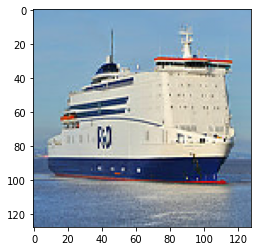

In [8]:
print(X_test.shape, Y_test.shape)

plt.imshow(X_test[6])
print(Y_test[6])

## Create data generators for _train_ and _val_ sets

<a id="section-dataset-3"></a>

Only one **data augmentation** transformation is randomly applied "online" (during training, when retrieving a batch): horizontal flipping.

The objective here is more to be invariant of the direction of the ship than to reduce overfitting (as adding more training samples could help the model to generalize).

In [9]:
from keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                   horizontal_flip=True,
                                   validation_split=VAL_SPLIT)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=IMG_DIM,
                                                    batch_size=BATCH_SIZE,
                                                    subset="training")

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                         target_size=IMG_DIM,
                                                         batch_size=BATCH_SIZE,
                                                         subset="validation")

Found 41641 images belonging to 13 classes.
Found 4621 images belonging to 13 classes.


<a id="section-two"></a>

# Create the model

Our model is based on the principles introduced by AlexNet [1]: several convolutional layers followed by max-pooling to extract significant features while gradually reducing image dimensions but increasing depth, dense units for the last layers and ReLU as the activation function.

AlexNet was applied to a similar computer vision task but with a larger dataset and approximately 1000 classes: ImageNet classification. Therefore our implementation is composed of less dense layers (and thus less trainable parameters) as our dataset is only composed of 13 classes.

We are using 4 "blocks", each one composed of the following layers in order: **Conv2D**, **BatchNormalization**, **Conv2D**, **BatchNormalization**, **MaxPooling** and **Dropout**. We rely on **BatchNormalization** layers to normalize inputs between layers and reduce training time and **Dropout** layers to reduce overfitting by setting values randomly to 0. At the end, a 256 dense  units are used before the final softmax layer which associates each class with a probability.

The intuition of chaining multiple convolutional layers before a max-pooling layer comes from several models that showed good results when applied to CIFAR-10 classification.

Finally, we use kernel regularizers on the first conv layers to prevent having large weight values which could cause overfitting.

---

[1] Krizhevsky, Alex; Sutskever, Ilya; Hinton, Geoffrey E. [ImageNet classification with deep convolutional neural networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). 2017 NIPS.

In [12]:
from tensorflow import keras

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras import regularizers

In [13]:
model = Sequential()

model.add(Input(shape=(IMG_DIM[0], IMG_DIM[1], 3)))

# First conv block (32 + 32 conv filters)
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second conv block (64 + 64 conv filters)
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Third conv block (128 + 128 conv filters)
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Fourth conv block (256 + 256 conv filters)
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(NB_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [14]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  29


<a id="section-three"></a>

# Train the model

We train the model until the training and validation losses stop decreasing.

Training was helpful to __find and adjust the architecture of our model according to the _bias–variance tradeoff___:
- When the model is not able to fit the training data (underfitting), both training and validation losses are high. In this case, we have a high bias and small variance. To solve this, we added more trainable parameters by adding more layers / neurons.
- When the model is overfitting the training data, validation loss is much higher than training loss. In this case, we have a low bias and high variance. To solve this, we added Dropout and tried kernel regularizers and increased the number of training samples with data augmentation.

## Configure optimizer and callbacks

<a id="section-train-1"></a>

We use the following settings to compile our model:
- **Optimizer**: Adam which combines interesting properties of both AdaGrad and RMSProp.
- **Loss function**: Common classification loss based on the crossentropy loss between the labels (represented as one-hot vectors) and predictions.
- **Metric**: Use accuracy score to evaluate model performances over epochs.

In [15]:
model.compile(optimizer='adam', # learning_rate=0.001
              metrics=['accuracy'],
              loss='categorical_crossentropy')

Callbacks used:

- `ModelCheckpoint`: keep the best weights by creating a checkpoint every time the validation loss improves.
- `EarlyStopping`: stop the training to avoid overfitting if the validation loss does not decrease after 5 epochs.
- `ReduceLROnPlateau`: divide by 10 the learning rate if the model struggles to converge.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./checkpoints/iren-1.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.0001,
                              verbose=1)

## Trainings

<a id="section-train-2"></a>

In [17]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    class_weight=class_weights,
                    epochs=30,
                    callbacks=[early_stopping, reduce_lr, save_callback])

Epoch 1/30
651/651 [==============================] - 66s 94ms/step - loss: 2.4292 - accuracy: 0.3482 - val_loss: 1.6868 - val_accuracy: 0.4977

Epoch 00001: val_loss improved from inf to 1.68679, saving model to ./checkpoints/iren-1.ckpt
Epoch 2/30
651/651 [==============================] - 60s 92ms/step - loss: 1.1099 - accuracy: 0.6774 - val_loss: 2.4787 - val_accuracy: 0.4350

Epoch 00002: val_loss did not improve from 1.68679
Epoch 3/30
651/651 [==============================] - 60s 93ms/step - loss: 0.7658 - accuracy: 0.7785 - val_loss: 3.4858 - val_accuracy: 0.3460

Epoch 00003: val_loss did not improve from 1.68679
Epoch 4/30
651/651 [==============================] - 60s 92ms/step - loss: 0.6596 - accuracy: 0.8109 - val_loss: 1.2793 - val_accuracy: 0.6399

Epoch 00004: val_loss improved from 1.68679 to 1.27931, saving model to ./checkpoints/iren-1.ckpt
Epoch 5/30
651/651 [==============================] - 60s 92ms/step - loss: 0.5563 - accuracy: 0.8425 - val_loss: 0.6968 - val

**Note**: The training stopped because the validation loss did not improved during 5 epochs.

In [18]:
history_2 = model.fit(train_generator,
                      validation_data=validation_generator,
                      class_weight=class_weights,
                      epochs=30,
                      callbacks=[early_stopping, reduce_lr, save_callback])

Epoch 1/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1257 - accuracy: 0.9643 - val_loss: 0.2185 - val_accuracy: 0.9362

Epoch 00001: val_loss improved from 0.22994 to 0.21851, saving model to ./checkpoints/iren-1.ckpt
Epoch 2/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1239 - accuracy: 0.9643 - val_loss: 0.2544 - val_accuracy: 0.9295

Epoch 00002: val_loss did not improve from 0.21851
Epoch 3/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1181 - accuracy: 0.9664 - val_loss: 0.2287 - val_accuracy: 0.9338

Epoch 00003: val_loss did not improve from 0.21851
Epoch 4/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1140 - accuracy: 0.9670 - val_loss: 0.2307 - val_accuracy: 0.9325

Epoch 00004: val_loss did not improve from 0.21851
Epoch 5/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1080 - accuracy: 0.9701 - val_loss: 0.2211 - val_accuracy: 0.9357

Epoch 00005: val_loss di

In [19]:
history_3 = model.fit(train_generator,
                      validation_data=validation_generator,
                      class_weight=class_weights,
                      epochs=30,
                      callbacks=[early_stopping, reduce_lr, save_callback])

Epoch 1/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1006 - accuracy: 0.9708 - val_loss: 0.2624 - val_accuracy: 0.9279

Epoch 00001: val_loss did not improve from 0.21851
Epoch 2/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1015 - accuracy: 0.9709 - val_loss: 0.2589 - val_accuracy: 0.9288

Epoch 00002: val_loss did not improve from 0.21851
Epoch 3/30
651/651 [==============================] - 60s 92ms/step - loss: 0.1025 - accuracy: 0.9705 - val_loss: 0.2274 - val_accuracy: 0.9355

Epoch 00003: val_loss did not improve from 0.21851
Epoch 4/30
651/651 [==============================] - 60s 92ms/step - loss: 0.0997 - accuracy: 0.9704 - val_loss: 0.2731 - val_accuracy: 0.9238

Epoch 00004: val_loss did not improve from 0.21851
Epoch 5/30
651/651 [==============================] - 60s 92ms/step - loss: 0.0941 - accuracy: 0.9728 - val_loss: 0.2306 - val_accuracy: 0.9344

Epoch 00005: val_loss did not improve from 0.21851
Epoch 6/30
651/651 [

**Observations**:
- The model converges after approximately 45 epochs as the train loss become steady.
- It took 45 minutes on a Tesla P100 GPU.
- The best validation loss was obtained after epoch 26.
- The model is slightly overfitting at the end but we use checkpoints to retrieve the best weights. This could be fixed by adding more dropout and enabling kernel regularizers on more layers.

In [21]:
model.load_weights(checkpoint_path)

<a id="section-four"></a>

# Evaluate the model

## Learning curves

<a id="section-evaluate-2"></a>

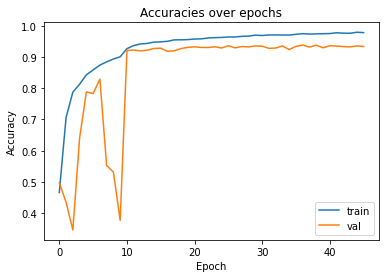

In [23]:
import matplotlib.pyplot as plt

def combine_histories_for_metric(histories, metric):
    res = []
    for h in histories:
        res += h.history[metric]
    return res

histories = [history, history_2, history_3]

total_accuracy = combine_histories_for_metric(histories, 'accuracy')
total_val_accuracy = combine_histories_for_metric(histories, 'val_accuracy')

plt.plot(total_accuracy)
plt.plot(total_val_accuracy)
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

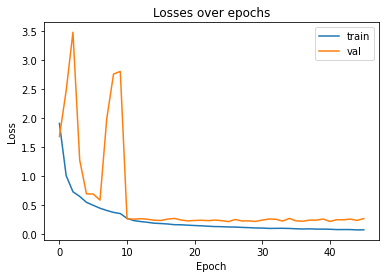

In [24]:
total_loss = combine_histories_for_metric(histories, 'loss')
total_val_loss = combine_histories_for_metric(histories, 'val_loss')

plt.plot(total_loss)
plt.plot(total_val_loss)
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Observations**:
- We are correctly fitting the training data as the training loss is constantly decreasing.
- The model is not overfitting as the validation loss is not increasing.
- The validation metrics were very unstable at the beginning of the training which is probably due to the weights varying a lot during the first epochs.
- We can notice that as the epochs progress, reaching a better accuracy takes way more time.

## Scores

<a id="section-evaluate-1"></a>

In [22]:
model.evaluate(X_test, Y_test)

41/41 [==============================] - 1s 13ms/step - loss: 0.2345 - accuracy: 0.9392


[0.23446659743785858, 0.939230740070343]

**Observations**:
- The accuracy tells us that our trained model is able to classify correctly approximately $94\%$ of the test set (which consists in images not used during training).
- We consider this as a good score especially because it is similar to the accuracy on the train and val sets.

In [36]:
from sklearn.metrics import classification_report

Y_test_pred = model.predict(X_test).argmax(axis=-1)

report = classification_report(Y_test.argmax(axis=-1),
                               Y_test_pred,
                               target_names=CATEGORIES,
                               zero_division=0)

print(report)

               precision    recall  f1-score   support

   coastguard       0.94      0.90      0.92       100
containership       0.93      0.98      0.96       100
     corvette       0.94      0.96      0.95       100
      cruiser       0.94      1.00      0.97       100
           cv       0.93      0.93      0.93       100
    destroyer       0.92      0.97      0.94       100
        ferry       0.96      0.87      0.91       100
    methanier       0.95      0.97      0.96       100
      sailing       0.96      0.95      0.95       100
    smallfish       0.95      0.90      0.92       100
    submarine       0.94      0.90      0.92       100
          tug       0.92      0.97      0.95       100
   vsmallfish       0.94      0.91      0.92       100

     accuracy                           0.94      1300
    macro avg       0.94      0.94      0.94      1300
 weighted avg       0.94      0.94      0.94      1300



**Notes**:

_Precision_ increases as we reduce the number of false positives (the model predicts the considered category but it is wrong).  
_Recall_ increases as we reduce the number of false negatives (the images of the considered category that we missed).

![Precision and recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb)  
![F1-score](https://wikimedia.org/api/rest_v1/media/math/render/svg/4179c69cf1dde8418c4593177521847e862e7df8)

**Observations**:
- The averaged F1-score is $0.94$ which is close to the value of $1.0$ which indicates a perfect balance between precision and recall.
- We can notice that some categories are easier to recognize: all `cruiser` images are correctly classified (but some other ships are incorrectly classified as `cruiser`). Cruise ships are easily distinguishable from other categories which confirms this result.

## Confusion matrix

<a id="section-evaluate-3"></a>

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

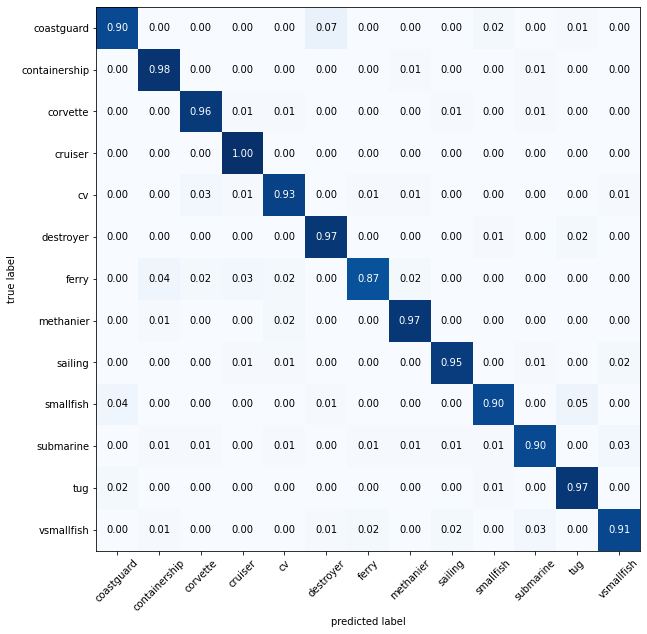

In [26]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(Y_test.argmax(axis=-1), Y_test_pred)

plot_confusion_matrix(cm,
                      class_names=CATEGORIES,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10))

**Observations**:
- Most images are correctly classified which explains why most predictions are on the diagonal.
- We can see that the model struggles to classify images of `ferry` ships as $4\%$ of them are classified as `containership` and an other $3\%$ are classified as `cruiser` (cruise and ferry ships usually look alike).
- Moreover, some errors are made between ships that look alike even for humans (classes `smallfish` and `vsmallfish`).

## Results analysis

<a id="section-evaluate-4"></a>

In [27]:
def plot_errors(X, Y, Y_pred, nb_images=30):
    plt.figure(figsize=(10, 15))
    
    pos_in_figure = 0
    for i in range(len(X)):
        if pos_in_figure >= nb_images:
            break

        if Y[i] == Y_pred[i]: # Skip correct predictions
            continue

        label_pred = CATEGORIES[Y_pred[i]]
        label_actual = CATEGORIES[Y[i]]
            
        plt.subplot(10, 5, pos_in_figure + 1)
        plt.imshow(X[i])            
        plt.title("Actual={}\n Pred={}".format(label_actual, label_pred))
        plt.axis("off")
        
        pos_in_figure += 1
    
    plt.tight_layout()
    plt.show()

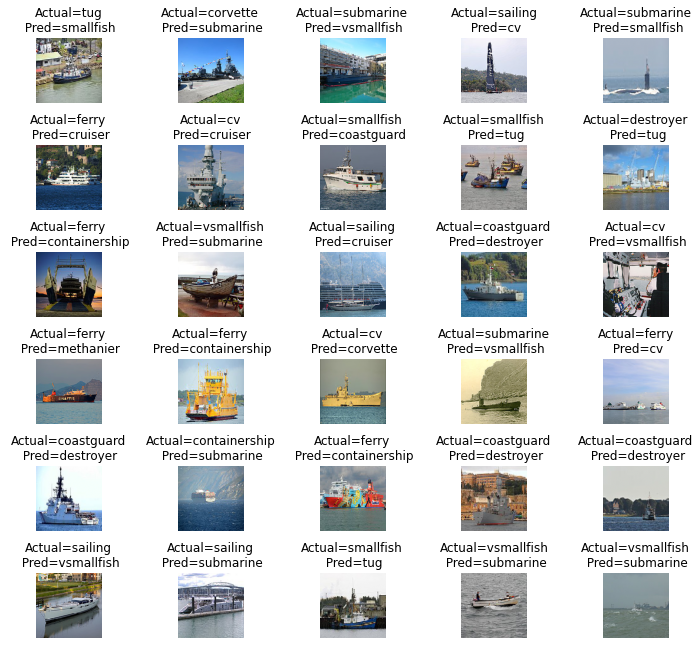

In [28]:
# Show errors made by the model
plot_errors(X_test, Y_test.argmax(axis=-1), Y_test_pred)

**Observations**:
- The figure above confirms the previous observation: images from categories `ferry` are often misclassified.
- We can notice that some errors are understandable:
    - 2nd row, 4th row: multiple ships appear on the same image ;
    - 3rd row, 5th row: the image was taken inside the ship ;
    - 6th row, 5th row: the ship is hidden in the background.

## Test with our own images

<a id="section-evaluate-5"></a>

In [29]:
def load_test_20_ships_set():
    X_test_20 = np.empty((20, IMG_DIM[0], IMG_DIM[1], 3))
    Y_test_20 = np.empty((20, NB_CLASSES))

    sample_index = 0
    for category_index, category in enumerate(CATEGORIES):
        images_path = glob.glob('/kaggle/input/our20ships/our-20-ships/' + category + '/*.jpg')

        for path in images_path:
            # Load and, normalize and resize image
            img = Image.open(path)
            img = img.resize((IMG_DIM[1], IMG_DIM[0]), Image.NEAREST)
            img = np.array(img) / 255.0

            # Store image and label value
            X_test_20[sample_index] = img
            Y_test_20[sample_index] = to_categorical(category_index, num_classes=NB_CLASSES)
            sample_index += 1
            
    return X_test_20, Y_test_20

# Test on our 20 ships images
X_test_20, Y_test_20 = load_test_20_ships_set()
print(X_test_20.shape, Y_test_20.shape)

(20, 128, 128, 3) (20, 13)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


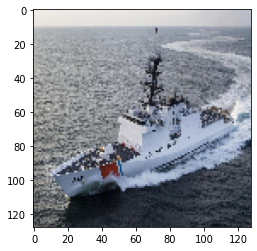

In [30]:
test_i = 0
plt.imshow(X_test_20[test_i])
print(Y_test_20[test_i])

In [31]:
model.evaluate(X_test_20, Y_test_20)

1/1 [==============================] - 0s 25ms/step - loss: 2.8272 - accuracy: 0.6500


[2.8271939754486084, 0.6499999761581421]

**Observations**:
- The model performs relatively well on unseen images by reaching a classification accuracy of $65\%$ where random would achieve $7\%$.
- It shows the ability of the model to work on images retrieved from a different distribution than the training set (as opposed to `X_test` which is created from the training set).

## Conclusion

<a id="section-evaluate-6"></a>

- We were able to achieve good results without advanced neural network techniques: a shallow CNN composed of 30 layers trained from scratch.
- We had to rely a lot on methods to reduce overfitting: dropout, kernel regularizers and early stopping.
- This situation is common in real life as having large labeled datasets is challenging for various domains. 

<a id="section-five"></a>

# Submit results for competition

**Note**: We noticed that the choice of algorithm for scaling images of `X_submission` has a strong impact on the results. We chose *bicubic interpolation* which usually gave the best accuracy and a more balanced histogram (displayed below). Other interpolation algorithms generate less predictions for categories trained with portrait oriented images (`coastguard`, `destroyer`, `smallfish`, `tug`) as the submission test set images are all landscape oriented.

In [33]:
import pandas as pd

X_submission = np.load('/kaggle/working/test.npy', allow_pickle=True)

# Resize test images to match our CNN input shape
X_submission_resized = np.empty((len(X_submission), IMG_DIM[0], IMG_DIM[1], 3))
for i in range(len(X_submission)):
    img = Image.fromarray(X_submission[i], 'RGB')
    img_resized = img.resize((IMG_DIM[1], IMG_DIM[0]), resample=Image.BICUBIC) # by default it is BICUBIC
    X_submission_resized[i] = np.array(img_resized)
    
X_submission_resized = X_submission_resized.astype('float32') / 255

# Determine predictions
res = model.predict(X_submission_resized).argmax(axis=1)
df = pd.DataFrame({"Category": res})
df.to_csv("reco_nav.csv", index_label="Id")

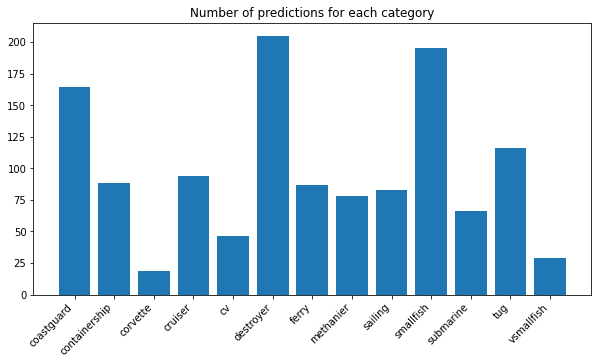

In [34]:
# Plot histogram of number of predictions for each category
fig = plt.figure(figsize=(10, 5))
plt.title("Number of predictions for each category")
plt.bar(CATEGORIES, np.bincount(res))
plt.xticks(rotation=45, ha="right")
plt.show()

In [35]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv